## This notebook show how to optimize qutrit readout shown in Figure 2

- The method is Q-CTRL method for subspace {01}, and we see it also applicable for subspace {12}
- We use the silhouette-score metric from the Scikit-learn library in Python to quantify these inter-distances. A heat map of the silhouette score as a function of pulse amplitudes and durations is generated to find the sweet spot for the qutrit performance. In Fig. 2 b, the amplitude is in the range of 0.4-1 in a normalized unit, and the duration sweeps from 2 to 5 μs. The optimal measurement spot is defined in association with an [amplitude, duration] pair that produces the highest score.


In [1]:
import time
from pathlib import Path
# Choose to run experiments or to use saved data
use_IBM = True
if use_IBM:
    timestr = time.strftime("%Y%m%d-%H%M%S")
    print("Time label for data saved throughout this experiment:" + timestr)
data_folder = Path.cwd()
import copy
import sys

import warnings

warnings.filterwarnings("ignore")

import pickle
from typing import Dict, List, Tuple

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from qiskit.qobj.utils import MeasLevel, MeasReturnType
from qiskit.scheduler import measure_all
from qiskit.visualization.pulse.qcstyle import SchedStyle
from qiskit.pulse.library import Waveform
import qiskit.pulse.library as pulse_lib

# Ignis discriminator fitter tools
from sklearn.svm import SVC
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, MeasurementFilter
from qiskit.ignis.measurement.discriminator.filters import DiscriminationFilter
from qiskit.ignis.measurement.discriminator.iq_discriminators import SklearnIQDiscriminator
from qiskit.ignis.measurement.discriminator.iq_discriminators import LinearIQDiscriminator
##
from scipy import interpolate, stats
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split


Time label for data saved throughout this experiment:20220814-104323


In [2]:
def add_modulation(pulse, freq: float, dt: float, scale: float = 1.) -> Waveform:
    """
    Add a modulation to the pulse.
    
    Args:
        samples: A list of AWG samples to modulate.
        freq: The frequency of the modulation to add to samples.
        dt: The cycle time.
        scale: a factor to scale the samples.
        
    Returns: SamplePulse with the added modulation.
    """
    
    if not isinstance(pulse, Waveform):
        samples = pulse.get_waveform().samples
    else:
        samples = pulse.samples
    
    modulated_samples = []
    for i, amp in enumerate(samples):
        modulated_samples.append(scale * amp * np.exp(2.0j*np.pi*freq*i*dt))
    
    return Waveform(modulated_samples)

In [3]:
# Q-CTRL auxiliary functions
def training_test_data(results, test_sample_size):
    """Randomly separate experiment results in a training and testing set for calibration and use of discriminators."""

    # Copy results object into a training object and a test object
    training_res = copy.deepcopy(results)
    test_res = copy.deepcopy(results)

    # Randomly select part of the results of for training/test of the discriminator
    (
        training_res.results[0].data.memory,
        test_res.results[0].data.memory,
    ) = train_test_split(results.results[0].data.memory, test_size=test_sample_size)
    (
        training_res.results[1].data.memory,
        test_res.results[1].data.memory,
    ) = train_test_split(results.results[1].data.memory, test_size=test_sample_size)

    return training_res, test_res

def calculate_avg_err(rabi_data):
    """Calculate average value and standard deviation of Rabi data."""
    rabi_data_avg = []
    rabi_data_err = []

    # Find average and standard deviation of Rabi data
    for i in range(len(rabi_data[0])):
        rabi_temp = []
        for j in range(len(rabi_data)):
            rabi_temp.append(rabi_data[j][i])

        # Calculate average of each data point
        rabi_data_avg.append(np.average(rabi_temp))

        # Calculate standard deviation
        rabi_data_err.append(
            np.sqrt(
                np.sum([(rabi_data_avg[i] - rabi) ** 2 for rabi in rabi_temp])
                / len(rabi_temp)
            )
        )

    return rabi_data_avg, rabi_data_err

def error_gamma(gamma, err_alpha, err_beta, err_f, alpha, beta):
    """Calculate error in the MLE estimation."""
    return (1 / (alpha - beta)) * np.sqrt(
        gamma ** 2 * err_alpha ** 2 + (gamma - 1) ** 2 * err_beta ** 2 + err_f ** 2
    )

def visibility(data):
    """Calculate the visibility of a sinusoidal signal."""
    I_max = np.max(data)
    I_min = np.min(data)
    return round((I_max - I_min) / (I_max + I_min), 2)

def ground_excited_experiment(qubit, backend, num_shots, measurement_schedule):
    """Run an experiment where the ground state is prepared and measured and the excited state is prepared and measured."""
    # Backend's default settings
    backend_defaults = backend.defaults()

    # Define default pi-pulse
    inst_sched_map = backend_defaults.instruction_schedule_map
    pi_default = inst_sched_map.get("x", qubits=backend_config.meas_map[meas_map_idx][qubit])

    # Create two schedules
    # Ground state schedule
    #gnd_schedule = pulse.Schedule(name="cal_00")
    #gnd_schedule += measurement_schedule

    # Excited state schedule
    exc_schedule = pulse.Schedule(name="cal_11")
    exc_schedule += measurement_schedule << exc_schedule.duration
    
    # Higher exicted state schedule
    hi_schedule = pulse.Schedule(name="cal_22")
    hi_schedule += pi_default
    #hi_schedule += pulse.Play(pi_pulse_12, drive_chan) << hi_schedule.duration
    hi_schedule += measurement_schedule << hi_schedule.duration
    hi_schedule.draw()
    # Assemble schedules into an experiment
    gnd_exc_program = assemble(
        [exc_schedule, hi_schedule],
        backend=backend,
        meas_level=1,
        meas_return="single",
        shots=num_shots,
        schedule_los=[{drive_chan: backend_defaults.qubit_freq_est[qubit]}] * 2,
    )

    # Run
    job = backend.run(gnd_exc_program)
    job_monitor(job)
    gnd_exc_results = job.result(timeout=120)

    return gnd_exc_results

def train_discriminator(
    gnd_exc_results, test_sample, discriminator=SklearnIQDiscriminator
):
    """Train a given discriminator to recognize I/Q data corresponding to excited and ground state using the results obtained in a ground/excited state experiment."""

    # Calibrate discriminator on gnd/exc state experiment
    gnd_exc_training_results, gnd_exc_test_results = training_test_data(
        gnd_exc_results, test_sample
    )

    trained_discriminator = []
    trained_discriminator.append(
        discriminator(svc, gnd_exc_training_results, [qubit], ["1", "2"])
    )
    # Collect ground state and excited state data to discriminate
    gnd_data = [data[0] for data in gnd_exc_test_results.results[0].data.memory]
    exc_data = [data[0] for data in gnd_exc_test_results.results[1].data.memory]

    # Store measurement result arrays for inter-cluster distance calculation in post-processing
    gnd_exc_data = np.concatenate((np.array(gnd_data), np.array(exc_data)))

    # Discriminate ground state data
    count_array = list(
        map(int, trained_discriminator[0].discriminate(gnd_data))
    )  # Turn the string of classified results into a list of integers 0 or 1
    probability_exc_gnd = np.sum(count_array) / len(
        count_array
    )  # To find probability of excited state, sum the elements of the count list (sum all the ones) and normalize by the number of elements
    probability_gnd_gnd = (
        1 - probability_exc_gnd
    )  # Find the probability of ground state

    # Discriminate excited state data
    count_array = list(map(int, trained_discriminator[0].discriminate(exc_data)))
    probability_exc_exc = np.sum(count_array) / len(count_array)
    probability_gnd_exc = 1 - probability_exc_exc

    return probability_exc_gnd, probability_exc_exc, gnd_exc_data, trained_discriminator



In [5]:
# Parameters
GHz = 1.0e9  # Gigahertz
MHz = 1.0e6  # Megahertz
us = 1.0e-6  # Microseconds
ns = 1.0e-9  # Nanoseconds
runs = 16  # Number of runs for collecting statistics
num_shots = 1024  # Number of times each program is repeated
num_shots_with_training = 8 * num_shots
test_sample_size = 0.167  # Size of sample for testing of discriminators
num_time_points = 50  # Number of points in the Rabi experiment
colors = {"Calibrated": "#680CE9", "Default": "#000000"}

if use_IBM:
    # IBM-Q imports
    import qiskit.pulse as pulse
#     import qiskit.pulse.pulse_lib as pulse_lib
    import qiskit.pulse.library as pulse_lib
    from qiskit import IBMQ
    from qiskit.compiler import assemble
    from qiskit.tools.jupyter import *
    from qiskit.tools.monitor import job_monitor

    # IBM credentials and backend selection
#     IBMQ.enable_account("YOUR TOKEN HERE")
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='your_project', group='your_group', project='your_project')
    backend = provider.get_backend("ibmq_jakarta")
    
    backend_defaults = backend.defaults()
    backend_config = backend.configuration()
    assert backend_config.open_pulse, "Backend doesn't support OpenPulse"

    # Backend properties
    qubit = 0
    qubit_freq_est = backend_defaults.qubit_freq_est[qubit]
    dt = backend_config.dt
    print(f"Qubit: {qubit}")
    print(f"Hardware sampling time: {dt/ns} ns")
    print(f"Qubit frequency estimate: {qubit_freq_est/GHz} GHz")

    # Set command channels
    drive_chan = pulse.DriveChannel(qubit)

    # Set measurement channels
    meas_chan = pulse.MeasureChannel(qubit)
    acq_chan = pulse.AcquireChannel(qubit)

    # Measurement map
    meas_map_idx = None
    for i, measure_group in enumerate(backend_config.meas_map):
        if qubit in measure_group:
            meas_map_idx = i
            break
    assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

else:
    qubit = 0
    dt = 2 / 9 * ns

# IBM-Q auxiliary functions
def get_closest_multiple_of_16(num):
    return int(num + 8) - (int(num + 8) % 16)


def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit


In [ ]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])
xp = inst_sched_map.get('x', qubits=qubit)
print(xp)
amp12 = 0.685
rxpulse12 = pulse_lib.gaussian(duration=160,
                                 amp=amp12, 
                                 sigma=40,
                                 name='pi_pulse_12')
pi_pulse_12 = add_modulation(rxpulse12, -0.33988*1.0e9, dt, scale=amp12)

In [27]:
if use_IBM:
    # Parameters for amplitude scan
    measurement_amp_min = 0.2
    measurement_amp_max = 1
    measurement_amp_steps = 10
    measurement_amp_array = np.linspace(
        measurement_amp_min, measurement_amp_max, measurement_amp_steps
    )

    # Parameters for duration scan
    measurement_samples_min = 2
    measurement_samples_max = 5
    measurement_samples_steps = 10
    measurement_samples_array = np.linspace(
        measurement_samples_min, measurement_samples_max, measurement_samples_steps
    )

    measurement_data = []
    silhouette_list = []

    # Iterate over amplitude values
    for measurement_amp in measurement_amp_array:
        print("\nAMPLITUDE:", measurement_amp, " a.u.")

        silhouette_time_list = []
        # Iterate over duration values
        for measurement_samples_us in measurement_samples_array:
            ### Construct the measurement pulse
            # Measurement pulse parameters
            measurement_sigma_us = (
                0.5  # Width of the gaussian part of the rise and fall in us
            )
            measurement_risefall_us = 0.1  # Truncating parameter: how many samples to dedicate to the risefall

            # Convert to machine format
            measurement_sigma = get_closest_multiple_of_16(
                measurement_sigma_us * 1e-6 / dt
            )
            measurement_risefall = get_closest_multiple_of_16(
                measurement_risefall_us * 1e-6 / dt
            )
            measurement_samples = get_closest_multiple_of_16(
                measurement_samples_us * 1e-6 / dt
            )
            print("DURATION:", measurement_samples_us, " a.u.")

            # Define measurement pulse
            measurement_pulse = pulse_lib.gaussian_square(
                duration=measurement_samples,
                sigma=measurement_sigma,
                amp=measurement_amp,
                risefall=measurement_risefall,
                name="measurement_pulse",
            )

            # Import backend configurations
            backend_config = backend.configuration()

            # Set measurement channels
            meas_chan = pulse.MeasureChannel(qubit)measure_schedule = pulse.Play(measurement_pulse, meas_chan)
            acq_chan = pulse.AcquireChannel(qubit)

            # Add a measurement stimulus on the measure channel pulse to trigger readout
            

            # Trigger data acquisition, and store measured values into respective memory slots
            measure_schedule += pulse.Acquire(
                measurement_pulse.duration,
                pulse.AcquireChannel(backend_config.meas_map[meas_map_idx][qubit]),
                pulse.MemorySlot(backend_config.meas_map[meas_map_idx][qubit]),
            )

            # Run 0-1 state discrimination experiment
            gnd_exc_experiment_result = ground_excited_experiment(
                qubit, backend, num_shots_with_training, measure_schedule
            )

            # Train and classify data with Q-CTRL's discriminator
            gnd_exc_results = train_discriminator(
                gnd_exc_experiment_result, test_sample_size
            )[2]

            # Store results
            measurement_data.append(gnd_exc_results)
            silhouette_time_list.append(silhouette_score(gnd_exc_results, labels=labels, metric='euclidean'))
            print(silhouette_score(gnd_exc_results, labels=labels, metric='euclidean'))
        silhouette_list.append(silhouette_time_list)

    # Save data
    filename = "measurement_amplitude_array" + timestr
    outfile = open(filename, "wb")
    pickle.dump(measurement_amp_array, outfile)
    outfile.close()
    filename = "measurement_samples_array" + timestr
    outfile = open(filename, "wb")
    pickle.dump(measurement_samples_array, outfile)
    outfile.close()
    filename = "measurements" + timestr
    outfile = open(filename, "wb")
    pickle.dump(measurement_data, outfile)
    outfile.close()
    filename = "silhouette_list" + timestr
    outfile = open(filename, "wb")
    pickle.dump(silhouette_list, outfile)
    outfile.close()
else:
    # Load data
    filename = data_folder / "measurement_amplitude_array"
    infile = open(filename, "rb")
    measurement_amp_array = pickle.load(infile)
    infile.close()
    filename = data_folder / "measurement_samples_array"
    infile = open(filename, "rb")
    measurement_samples_array = pickle.load(infile)
    infile.close()
    filename = data_folder / "measurements"
    infile = open(filename, "rb")
    measurement_data = pickle.load(infile)
    infile.close()
    filename = data_folder / "silhouette_list"
    infile = open(filename, "rb")
    silhouette_list = pickle.load(infile)
    infile.close()
    


AMPLITUDE: 0.2  a.u.
DURATION: 2.0  a.u.
Job Status: job has successfully run
0.3044115494286437
DURATION: 2.3333333333333335  a.u.
Job Status: job has successfully run
0.36382525703815555
DURATION: 2.6666666666666665  a.u.
Job Status: job has successfully run
0.421852329825041
DURATION: 3.0  a.u.
Job Status: job has successfully run
0.44465808013089675
DURATION: 3.333333333333333  a.u.
Job Status: job has successfully run
0.5270677973648386
DURATION: 3.6666666666666665  a.u.
Job Status: job has successfully run
0.5548052588914957
DURATION: 4.0  a.u.
Job Status: job has successfully run
0.5875690194169377
DURATION: 4.333333333333333  a.u.
Job Status: job has successfully run
0.6197362549017563
DURATION: 4.666666666666666  a.u.
Job Status: job has successfully run
0.6116059141698844
DURATION: 5.0  a.u.
Job Status: job has successfully run
0.6142934788418588

AMPLITUDE: 0.2888888888888889  a.u.
DURATION: 2.0  a.u.
Job Status: job has successfully run
0.4654137540329158
DURATION: 2.33333

In [6]:
# Load data
filename = data_folder / "measurement_amplitude_array20220212-124518"
infile = open(filename, "rb")
measurement_amp_array = pickle.load(infile)
infile.close()
filename = data_folder / "measurement_samples_array20220212-124518"
infile = open(filename, "rb")
measurement_samples_array = pickle.load(infile)
infile.close()
filename = data_folder / "measurements20220212-124518"
infile = open(filename, "rb")
measurement_data = pickle.load(infile)
infile.close()
filename = data_folder / "silhouette_list20220212-124518"
infile = open(filename, "rb")
silhouette_list = pickle.load(infile)

# The silhouette score heat map as a function of durations and amplitudes of the measurement pulses

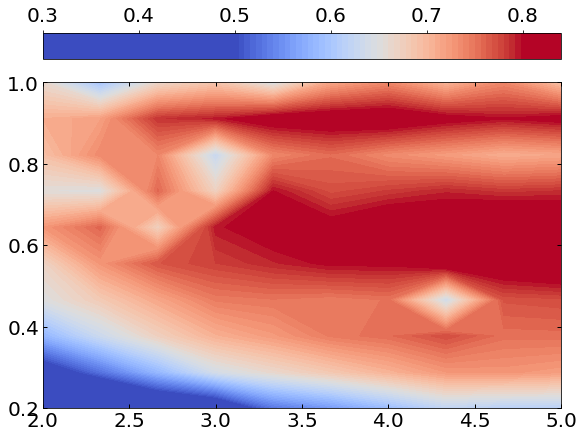

In [9]:
# Plot landscape of probability of excited state
fig, ax = plt.subplots(1, constrained_layout=True)
fig.set_figheight(6)
fig.set_figwidth(8)

Y = measurement_amp_array
X = measurement_samples_array
X, Y = np.meshgrid(X, Y)
Z0 = silhouette_list

cs = ax.contourf(
    X,
    Y,
    Z0,
    len(measurement_amp_array) * len(measurement_samples_array),
    cmap="coolwarm",
    vmin=0.5,
    vmax=0.8,
)
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)

# cb_ax = fig.add_axes([1.02, 0.01, 0.03, 0.96])
# cbar1 = fig.colorbar(cs, cax=cb_ax, orientation="horizontal")
# cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
# cbar1 = fig.colorbar(cs, cax=cax, orientation="horizontal")
cbar1 = fig.colorbar(cs, orientation="horizontal", location = 'top')
cbar1.set_ticks(np.arange(0.3, 0.841, 0.1))

cbar1.ax.tick_params(labelsize=20)
# ax.set_ylabel("Amplitude", fontsize=20, rotation=90)
# ax.set_xlabel(r"Time [$\mu$s]", fontsize=20, rotation=0)
# ax.set_title("Silhouette score", fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.set_xticks(np.arange(2, 5.1, 0.5))
ax.set_yticks(np.arange(0.2, 1.02, 0.2))
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis="x", direction='in', length=4, width=1, color="black")
ax.tick_params(axis="y", direction="in", length=4, width=1, color="black")
# ax.set_yticklabels([])
# ax.set_xticklabels([])
# plt.tick_params(bottom = False)
# plt.tick_params(left = False)
# cb_ax = fig.add_axes([1.02, 0.12, 0.02, 0.8])
# # ax.legend(loc="lower left", fontsize=14)

# fig.savefig('silhouette_sweep.svg',dpi=240)
fig.savefig('/hanoipho/Desktop/paper_neu_figs/silhouette_sweep.svg',dpi=240)


We found that the high score points yield good {012} discriminator